# Project Notebook
Authors:
* Brocco Mattia
* Tellez Brenda

In [2]:
from google.colab import drive
drive.mount("/content/drive")

%cd /content/drive/MyDrive/Environmental-sounds-UNIPD-2022

Mounted at /content/drive
/content/drive/MyDrive/Environmental-sounds-UNIPD-2022


In [3]:
import os
import sys
import torch
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy.io import wavfile
from tensorflow import keras
import matplotlib.pyplot as plt

import evaluation
import CNN_support as cnns
from gng import GrowingNeuralGas

%load_ext autoreload
%autoreload 2

In [6]:
data = pd.read_csv('./data/meta/esc50.csv')
data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


## 1. CNN for audio classification

##### SOURCES
[1] [CNN for audio (MEDIUM)](https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab)  
[2] [Types of DCT](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.dct.html#scipy.fftpack.dct)

Default sampling rate of `librosa` is 22050, while for `scipy` is 44100. This implies that we have half of the length of the sequence with the former library (110250 against 220500).  

In [ ]:
#pppp = cnns.SoundPreprocessing(n_fft = 1000, n_mfcc = 10, sr = 441000, max_size = (200, 1000))

#W, Z = pppp.get_features(df = data, filepath = ".\\data\\audio")

In [ ]:
#s, a = wavfile.read(".\\data\\audio\\{}".format(data.loc[10, "filename"]))
#a = a.astype(np.float32)

In [ ]:
#mfcc_try = librosa.feature.mfcc(y = a, sr = s, hop_length = 512, n_mfcc = 60)
#mfcc_try = np.divide(mfcc_try, np.linalg.norm(mfcc_try))
#chromogram_try = librosa.feature.chroma_stft(y = a, sr = s, hop_length = 512,
#                                             win_length = 1024, n_chroma = 60)

## Preprocessing

In [13]:
# Get data for CNN
X = []
y = np.zeros(shape = (len(data), 1))

for i in data.index:
    
    sr, aud = wavfile.read("./data/audio/{}".format(data.loc[i, "filename"]))
    aud = aud.astype(np.float32)
    
    MFCC = librosa.feature.mfcc(y = aud, sr = sr, hop_length = 512, n_mfcc = 60)
    chromagram = librosa.feature.chroma_stft(y = aud, sr = sr, hop_length = 512,
                                             win_length = 1024, n_chroma = 60)
    delta = librosa.feature.delta(MFCC)
    
    instance = np.dstack((MFCC, chromagram, delta))
    
    X += [instance]
    
    y[i] = data.loc[i, "target"]
    
X = np.array(X)

/usr/local/lib/python3.8/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
# Data Augmentation
# SOURCE: https://medium.com/@makcedward/data-augmentation-for-audio-76912b01fdf6

np.random.seed(42)
indexed_samples = np.random.choice(X.shape[0], size = 4000,
                                   replace = True)
np.random.seed(101)
randn_seeds = np.random.choice(5000, size = 4000,
                               replace = False)

new_X = []
new_y = np.zeros(shape = (len(indexed_samples), 1))
for n, i in enumerate(indexed_samples):
    
    sr_sample, sample = wavfile.read("./data/audio/{}".format(data.loc[i, "filename"]))
    sample = sample.astype(np.float32)
    
    if n%5 == 0:
        # NOISE INJECTION
        np.random.seed(randn_seeds[n])
        noise = np.random.randn(len( sample ))
        augmented_data = (sample + noise).astype(np.float32)
        
    elif n%5 == 1:
        # TIME SHIFT: right shift
        np.random.seed(randn_seeds[n])
        shift = -1*np.random.randint(sr_sample * 0.2) # 0.2 length of sequence max
        augmented_data = np.roll(sample, shift)
        # Set to silence for heading/ tailing
        augmented_data[shift:] = 0
        
    elif n%5 == 2:
        # PITCH SHIFT: shift down by 3
        augmented_data = librosa.effects.pitch_shift(y = sample, sr = sr_sample,
                                                     n_steps = 3)
    elif n%5 == 3:
        # SPEED SHIFT: faster
        augmented_data = librosa.effects.time_stretch(y = sample, rate = 1.2)
        augmented_data = np.append(augmented_data,
                                   np.zeros(shape = len(sample) - len(augmented_data)))
    else:
        # SPEED SHIFT: slower (returns longer array)
        augmented_data = librosa.effects.time_stretch(y = sample, rate = 0.8)
        augmented_data = augmented_data[:len(sample)]
    
    
    new_MFCC = librosa.feature.mfcc(y = augmented_data, sr = sr_sample,
                                    hop_length = 512, n_mfcc = 60)
    new_chromagram = librosa.feature.chroma_stft(y = augmented_data, sr = sr_sample,
                                                 hop_length = 512, win_length = 1024,
                                                 n_chroma = 60)
    new_delta = librosa.feature.delta(new_MFCC)
    
    new_instance = np.dstack((new_MFCC, new_chromagram, new_delta))
    
    new_X += [new_instance]
    new_y[n] = y[i]
    
new_X = np.array(new_X)

/usr/local/lib/python3.8/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
# Get stuff together
X = np.vstack((X, new_X))
y = np.vstack((y, new_y))

In [ ]:
X.shape, y.shape

((6000, 60, 431, 3), (6000, 1))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .75, random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size = .8, random_state = 42)

print("Training examples: {}".format(y_train.shape[0]))
print("Validation examples: {}".format(y_valid.shape[0]))
print("Test examples: {}".format(y_test.shape[0]))
print()
print("Input shape: {}".format(X_train[0].shape))

Training examples: 3600
Validation examples: 900
Test examples: 1500

Input shape: (60, 431, 3)


## Algo tries

In [ ]:
#def array4D_to_parquet(arr, name):
#  arr2 = pd.DataFrame(arr.reshape(arr.shape[0], -1))
#  arr2.columns = [str(c) for c in arr2.columns]
#  arr2.to_parquet(os.getcwd() + f"/data/{name}.parquet")

#def target_to_parquet(arr, name):
#  arr2 = pd.DataFrame(arr)
#  arr2.columns = [str(c) for c in arr2.columns]
#  arr2.to_parquet(os.getcwd() + f"/data/{name}.parquet")


#array4D_to_parquet(X_train, "X_train")
#array4D_to_parquet(X_valid, "X_valid")
#array4D_to_parquet(X_test, "X_test")

#target_to_parquet(y_train, "y_train")
#target_to_parquet(y_valid, "y_valid")
#target_to_parquet(y_test, "y_test")

In [14]:
# ---------------------------- #
# LOAD DATA FROM PARQUET FILES #
# ---------------------------- #

X_train = pd.read_parquet(".//data/X_train.parquet")
X_valid = pd.read_parquet(".//data/X_valid.parquet")
X_test = pd.read_parquet(".//data/X_test.parquet")
y_train = pd.read_parquet(".//data/y_train.parquet")
y_valid = pd.read_parquet(".//data/y_valid.parquet")
y_test = pd.read_parquet(".//data/y_test.parquet")

X_train = X_train.values.reshape(X_train.shape[0], 60, 431, 3)
X_valid = X_valid.values.reshape(X_valid.shape[0], 60, 431, 3)
X_test = X_test.values.reshape(X_test.shape[0], 60, 431, 3)

y_train = y_train.values
y_valid = y_valid.values
y_test = y_test.values

In [18]:
BATCH_SIZE1 = int(X_train.shape[0]/20)

In [15]:
# Identify and select the TPU
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.TPUStrategy(tpu)
except:
  pass

In [16]:
with tpu_strategy.scope():
  # creating the model in the TPUStrategy
  # scope means we will train the model on the TPU
  model0 =  keras.models.Sequential([keras.layers.Conv2D(filters = 30, kernel_size = [12, 6],
                                                         padding = "same", activation = "relu",
                                                         input_shape = [60, 431, 3]),
                                     keras.layers.MaxPool2D(pool_size = (3, 3), strides = (1, 3)),
                                     keras.layers.Dropout(rate = .5),
                                     keras.layers.Conv2D(filters = 30, kernel_size = (1, 3),
                                                         padding = "same", activation = "relu"),
                                     keras.layers.MaxPool2D(pool_size = (1, 3), strides = (1, 3)), # DON'T TOUCH THIS LAYER
                                     keras.layers.Conv2D(filters = 10, kernel_size = (1, 3),
                                                         padding = "same", activation = "relu"),
                                     keras.layers.MaxPool2D(pool_size = (1, 3), strides = (1, 3)),
                                     keras.layers.Flatten(),
                                     keras.layers.Dense(500, activation = "relu"), # BOOSTS PERFORMANCE
                                     keras.layers.Dropout(rate = .5),
                                     keras.layers.Dense(50, activation = "softmax") ],
                                    name = "M0")

  model0.compile(loss = "sparse_categorical_crossentropy", metrics = ["accuracy"],
                 optimizer = keras.optimizers.Adam(learning_rate = 1e-4))

print(model0.summary())

Model: "M0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 431, 30)       6510      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 58, 143, 30)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 58, 143, 30)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 143, 30)       2730      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 47, 30)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 47, 10)        910      


47/47 - 6s - loss: 1.3801 - accuracy: 0.7020 - 6s/epoch - 122ms/step
Accuracy on test: 70.20%
Memory used: 1192.2 Mb


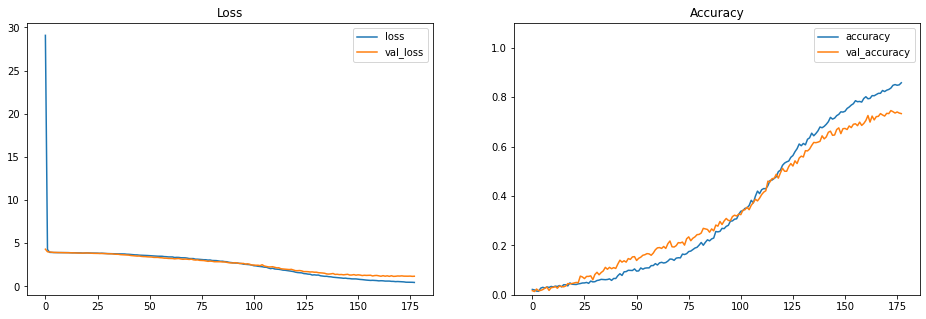

In [19]:
history0 = model0.fit(X_train, y_train, epochs = 200, batch_size = BATCH_SIZE1,
                      validation_data = (X_valid, y_valid), verbose = 0,
                      callbacks = [keras.callbacks.EarlyStopping(patience = 10)])

fig0, ax0 = plt.subplots(1, 2, figsize = (16, 5))
evaluation.plot_loss(history0, ax0[0])
evaluation.plot_accuracy(history0, ax0[1])

print()
scores0 = model0.evaluate(X_test, y_test, verbose = 2)
print("="*71)
print("Accuracy on test: {:.2f}%".format(scores0[1]*100))
print("Memory used: {:.1f} Mb".format(
        evaluation.keras_model_memory_usage_in_bytes(model = model0,
                                                     batch_size = BATCH_SIZE1)/1e6))

---
---
---